In [0]:
#basic interface of invertible net, invertible generator, and stacking invertible nets
import torch

class FlowModule(torch.nn.Module):
  
  def __init__(self, *args):
    super(FlowModule, self).__init__()

  def inverse(self, *input):
  #returns value of latent variable, as well as the logarithm of the absolute value of the determinant of the Jacobian
    raise NotImplementedError

class FlowGenerator(torch.nn.Module):

  def __init__(self, net, prior):
    assert(isinstance(net, FlowModule))
    assert(isinstance(prior, torch.distributions.distribution.Distribution))
    super(FlowGenerator, self).__init__()
    self._net = net
    self._prior = prior
    
  def forward(self, n):
  #sample n times
    x = self._prior.sample(torch.Size([n]))
    x = self._net(x)
    return x

  def log_p(self, x):
    z, log_abs_det = self._net.inverse(x)
    return prior.log_prob(z) + log_abs_det
  
  def crossentropy_loss(self, x):
    return -1. * (self.log_p(x)).mean()

class FlowStack(torch.nn.Sequential, FlowModule):
  
  def __init__(self, *args):
    for net in args:
      assert(isinstance(net, FlowModule))
    super(FlowStack, self).__init__(*args)

  def inverse(self, input):
    log_abs_det = 0.
    for module in reversed(self._modules.values()):
      input, delta = module.inverse(input)
      log_abs_det += delta
    return input, log_abs_det

In [0]:
#coupling layer from realNVP paper
import torch

class CouplingLayer(FlowModule):
  
  def __init__(self, s, t, mask):
    assert(isinstance(s, torch.nn.Module))
    assert(isinstance(t, torch.nn.Module))
    assert(isinstance(mask, torch.ByteTensor))
    super(CouplingLayer, self).__init__()
    self._s = s
    self._t = t
    self.register_buffer("mask", mask)
    
  def forward(self, x):
    x_ = torch.where(self.mask, x, torch.zeros_like(x))
    scale = torch.where(~self.mask, self._s(x_), torch.zeros_like(x_))
    trans = torch.where(~self.mask, self._t(x_), torch.zeros_like(x_))
    x = torch.where(~self.mask, x * torch.exp(scale) + trans, x_)
    return x
  
  def inverse(self, x):
    x_ = torch.where(self.mask, x, torch.zeros_like(x))
    scale = torch.where(~self.mask, self._s(x_), torch.zeros_like(x_))
    trans = torch.where(~self.mask, self._t(x_), torch.zeros_like(x_))
    x = torch.where(~self.mask, (x - trans) * torch.exp(-1. * scale), x_)
    log_det = -1. * scale.sum(dim=1)
    return x, log_det

In [0]:
#helper functions for initialization of (stacks of) coupling layers
import torch

def create_mask(n, p=0.5):
  idx = torch.randperm(n).byte()
  mask = torch.where(idx > p * (n - 1), torch.ones_like(idx), torch.zeros_like(idx))
  return mask

def create_t(n, h=[256,256]):
  net = torch.nn.Linear(n, h[0])
  for layer in range(1, len(h)):
    net = torch.nn.Sequential(net, torch.nn.LeakyReLU(), torch.nn.Linear(h[layer-1], h[layer]))
  net = torch.nn.Sequential(net, torch.nn.LeakyReLU(), torch.nn.Linear(h[-1], n))
  return net

def create_s(n, h=[256,256]):
  net = create_t(n, h)
  net = torch.nn.Sequential(net, torch.nn.Tanh())
  return net
  
def create_2cl(n, p=0.5, ht=[256,256], hs=[256,256]):
  mask = create_mask(n, p)
  t1 = create_t(n, ht)
  t2 = create_t(n, ht)
  s1 = create_s(n, hs)
  s2 = create_s(n, hs)
  cl1 = CouplingLayer(s1, t1, mask)
  cl2 = CouplingLayer(s2, t2, ~mask)
  return FlowStack(cl1, cl2)

def create_flownet(n, d=3, p=None, ht=None, hs=None):
  if p is None: p = [0.5] * d
  if ht is None: ht = [[256,256]] * d
  if hs is None: hs = [[256,256]] * d
  assert(len(p) == len(ht) == len(hs) == d)
  net = create_2cl(n, p[0], ht[0], hs[0])
  for i in range(1, d):
    net = FlowStack(net, create_2cl(n, p[i], ht[i], hs[i]))
  return net

In [6]:
#main cell
device = torch.device("cuda")
n = 2
mynet = create_flownet(n)
prior = torch.distributions.MultivariateNormal(torch.zeros(n).to(device), torch.eye(n).to(device))
mygen = FlowGenerator(mynet, prior).to(device)
optimizer = torch.optim.Adam(mygen.parameters())
batches = 5000
batchsize = 100

import sklearn.datasets
import numpy

for t in range(batches):
  noisy_moons = torch.from_numpy(sklearn.datasets.make_moons(n_samples=batchsize, noise=0.05)[0].astype(numpy.float32)).to(device)
  #we need noise because target distribution needs to be smooth enough for our model to fit
  loss = mygen.crossentropy_loss(noisy_moons)
  optimizer.zero_grad()
  loss.backward()
  if (t%500 == 0):
    print(t, loss.item())
  optimizer.step()

0 2.493985652923584
500 0.6992393136024475
1000 1.0623993873596191
1500 0.6122843623161316
2000 0.6103793382644653
2500 0.4893724322319031
3000 0.5356952548027039
3500 0.5507103800773621
4000 0.4138577878475189
4500 0.32981327176094055


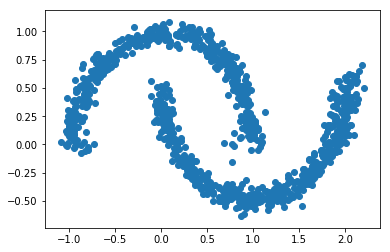

In [7]:
import matplotlib.pyplot as plt

x = mygen(1000).detach().cpu().numpy()
plt.scatter(x[:,0], x[:,1])